# QAOA for the SK spin-glass model

 In this notebook, we use Quantum Approximate Optimization Algorithm (**QAOA**) to find low energy states of the **Sherrington-Kirkpatrick** (SK) **spin-glass** model. In particular, we optimally build the transpiled QAOA circuit such that it involves a smaller number of two-qubit gates, hence reducing the exposure to noise and thus improving the results. We implement the algorithm on IQM Garnet, a 20-qubit quantum computer with square lattice topology.


In order to follow this example or start experimenting with your own problems using IQM Garnet, make sure to have all packages in the appropriate version installed.

In [ ]:
%%capture
!pip install "iqm-client[qiskit]"
!pip install networkx
!pip install matplotlib
!pip install pylatexenc

## Connecting to IQM Garnet via IQM Resonance

In order to access IQM Garnet through IQM Resonance, you will need to create an API Token. Go to [resonance.meetiqm.com](https://resonance.meetiqm.com), create and copy the token, execute the cell, and paste the token to store it as an environment variable (or follow the guidelines for your system to create an environment variable).

If you need more information about Resonance, you can watch this introductory video 👉 [Getting Started with IQM Resonance](https://youtu.be/V5yYgDIhqUo).

In [1]:
import os
token = "your token here"
os.environ["IQM_TOKEN"] = token

Then, we can start by connecting to IQM Resonance and create a `backend` object that we will use later.

In [2]:
from iqm.qiskit_iqm import IQMProvider
provider = IQMProvider(url="https://cocos.resonance.meetiqm.com/garnet")
backend = provider.get_backend()

## Problem instance

For the purpose of this demonstration, we will find low energy states of the SK Hamiltonian. The SK model is a well-known theoretical model of spin glasses introduced by David Sherrington and Scott Kirkpatrick in 1975.
Spin glasses are disordered spin systems where the orientation of spins does not follow an ordered structure, such as in ferromagnets or antiferromagnets, but instead, spins take a random configuration due to the competing interactions between neighboring spins, which can be either ferromagnetic (favoring alignment) or antiferromagnetic (favoring opposite alignment). As a result, spin glasses exhibit **frustration**, a condition where not all interactions can be simultaneously favorably aligned, leading to complex energy landscapes with many local minima.

The SK model is characterized by a complete graph, meaning a graph with an edge between every pair of vertices, and a randomly assigned weight $J_{ij}$ to each edge $ij$. Here, we consider the case where each edge takes weight -1 or +1 with equal probability 50%.

   

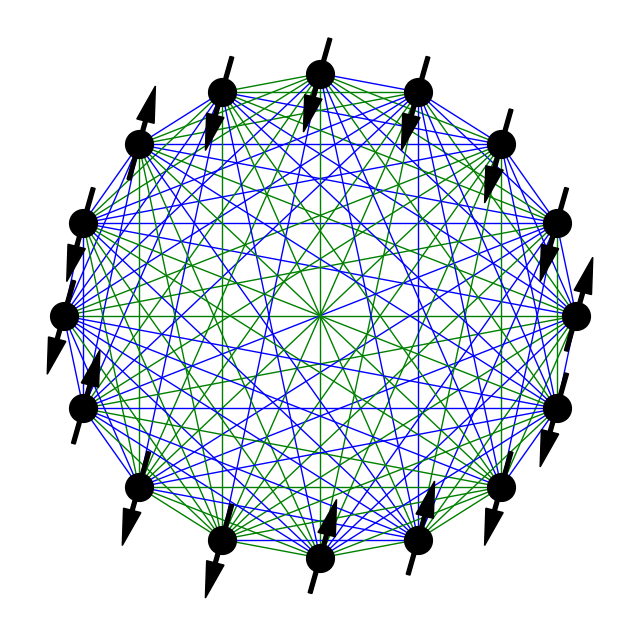

In [1]:
from IPython.display import Image, display
display(Image(filename="spin_glass.png"))

By associating a spin variable to each node of the graph, each pair of vertices will contribute the energy $E_{ij} = J_{ij} Z_i Z_j$ (which can take value -1 or +1) to the total energy $H=\sum_{<ij>}E_{ij}$ of the system. The problem here is to find a spin configuration that has globally the lowest energy.

Finding the exact ground-state configuration of the SK model is NP hard. However, this model and also spin-glasses in general have many applications. Up to some extent, all Quadratic Binary Unconstrained Optimization (QUBO) problems can be seen as spin-glass problems, where the couplings $J_{ij}$ can e.g. describe real-world data. For example, in **portfolio optimization** in finance the $J_{ij}$ would represent a time average over the price and fluctuations of a set of assets.    

> As a side note, in 2021 the nobel prize in physics was awarded to G. Parisi for his contributions in the theoretical understanding of spin-glasses, highlighting the relevance of the model. 

To begin, let's choose a complete graph on n=4 nodes and associate random weights to its edges. The weights can be arranged in a symmetric matrix in which the diagonal elements are zeros and the non-diagonal elements are either -1 or +1.

In [3]:
import numpy as np

n = 4
W = np.zeros((n, n), dtype=int)
triu_indices = np.triu_indices(n, k=1)
W[triu_indices] = np.random.choice([-1, 1], size=n*(n-1)//2)
W = W + W.T
print(W)

[[ 0 -1  1 -1]
 [-1  0  1  1]
 [ 1  1  0  1]
 [-1  1  1  0]]


## Building the QAOA circuit

At the heart of QAOA is a parametrized quantum circuit designed to tackle complex optimization problems, like the SK problem. The QAOA circuit is designed to efficiently explore the solution space of a given problem. It is composed of a series of alternating layers of single-qubit rotations and two-qubit interactions. By adjusting the parameters in the circuit, QAOA aims to find the optimal configuration that maximizes or minimizes a specific objective function. This objective function can be viewed as the global energy of a given system.

QAOA operates by encoding the problem into a **problem hamiltonian** whose ground state represents the optimal solution. The dynamics of the problem hamiltonian is encoded in a quantum computer by a circuit representing the **problem unitary**. Correspondingly, a circuit representing the so-called **mixer unitary** is used to explore more possible solutions to the problem. By alternating between the application of the problem unitary and the mixer unitary, QAOA evolves the quantum system toward the ground state of the problem Hamiltonian, which corresponds to the optimal solution of the combinatorial optimization problem. 

This process is facilitated by a classical optimization loop that is minimizing the expectation value of the problem hamiltonian, helping us getting closer to its ground state.

In this tutorial, we are considering one layer of QAOA. We create and show the corresponding circuit in the code cell below.


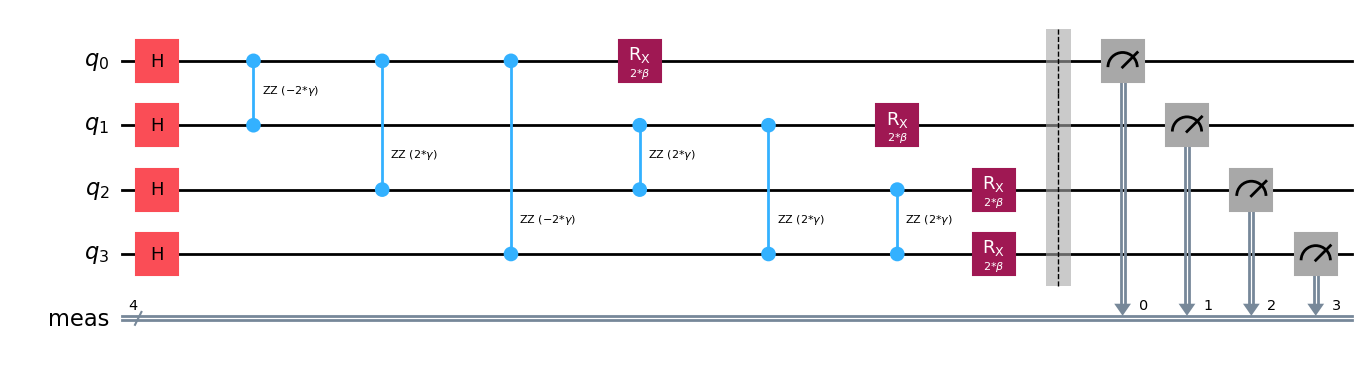

In [4]:
from qiskit.circuit import Parameter
from iqm.qiskit_iqm import IQMCircuit

num_qubits = 4

def create_qaoa_circuit(num_qubits, theta, W):
    qc = IQMCircuit(num_qubits)
    gamma = theta[0]
    beta = theta[1]

    # initializing the quantum register in a uniform superposition state
    for i in range(num_qubits):
        qc.h(i)

    # problem circuit
    for i in range(num_qubits-1):
            for j in range(i+1,num_qubits):
                qc.rzz(2 * W[i][j] * gamma , i, j)

    # mixer
    for i in range(num_qubits):
        qc.rx(2 * beta, i)

    qc.measure_all()
    
    return qc


theta = [Parameter("$\\gamma$"), Parameter("$\\beta$")]
circ_qaoa = create_qaoa_circuit(num_qubits, theta, W)
circ_qaoa.draw("mpl", fold=-1)

For the single layer QAOA, we avoid the QAOA optimization loop and find the optimal angles without executing the circuit. Using this approach, we find the close-to-optimal angles by initializing the optimizer with different random initial angles. Having found the optimal angles, we build and transpile the circuit.


> You can find more information about the results for the one-layer QAOA in this paper: [Expectation values from the single-layer quantum approximate optimization algorithm on Ising problems](https://iopscience.iop.org/article/10.1088/2058-9565/ac9013). This is what is implemented in the `get_energy_p1` function used below.

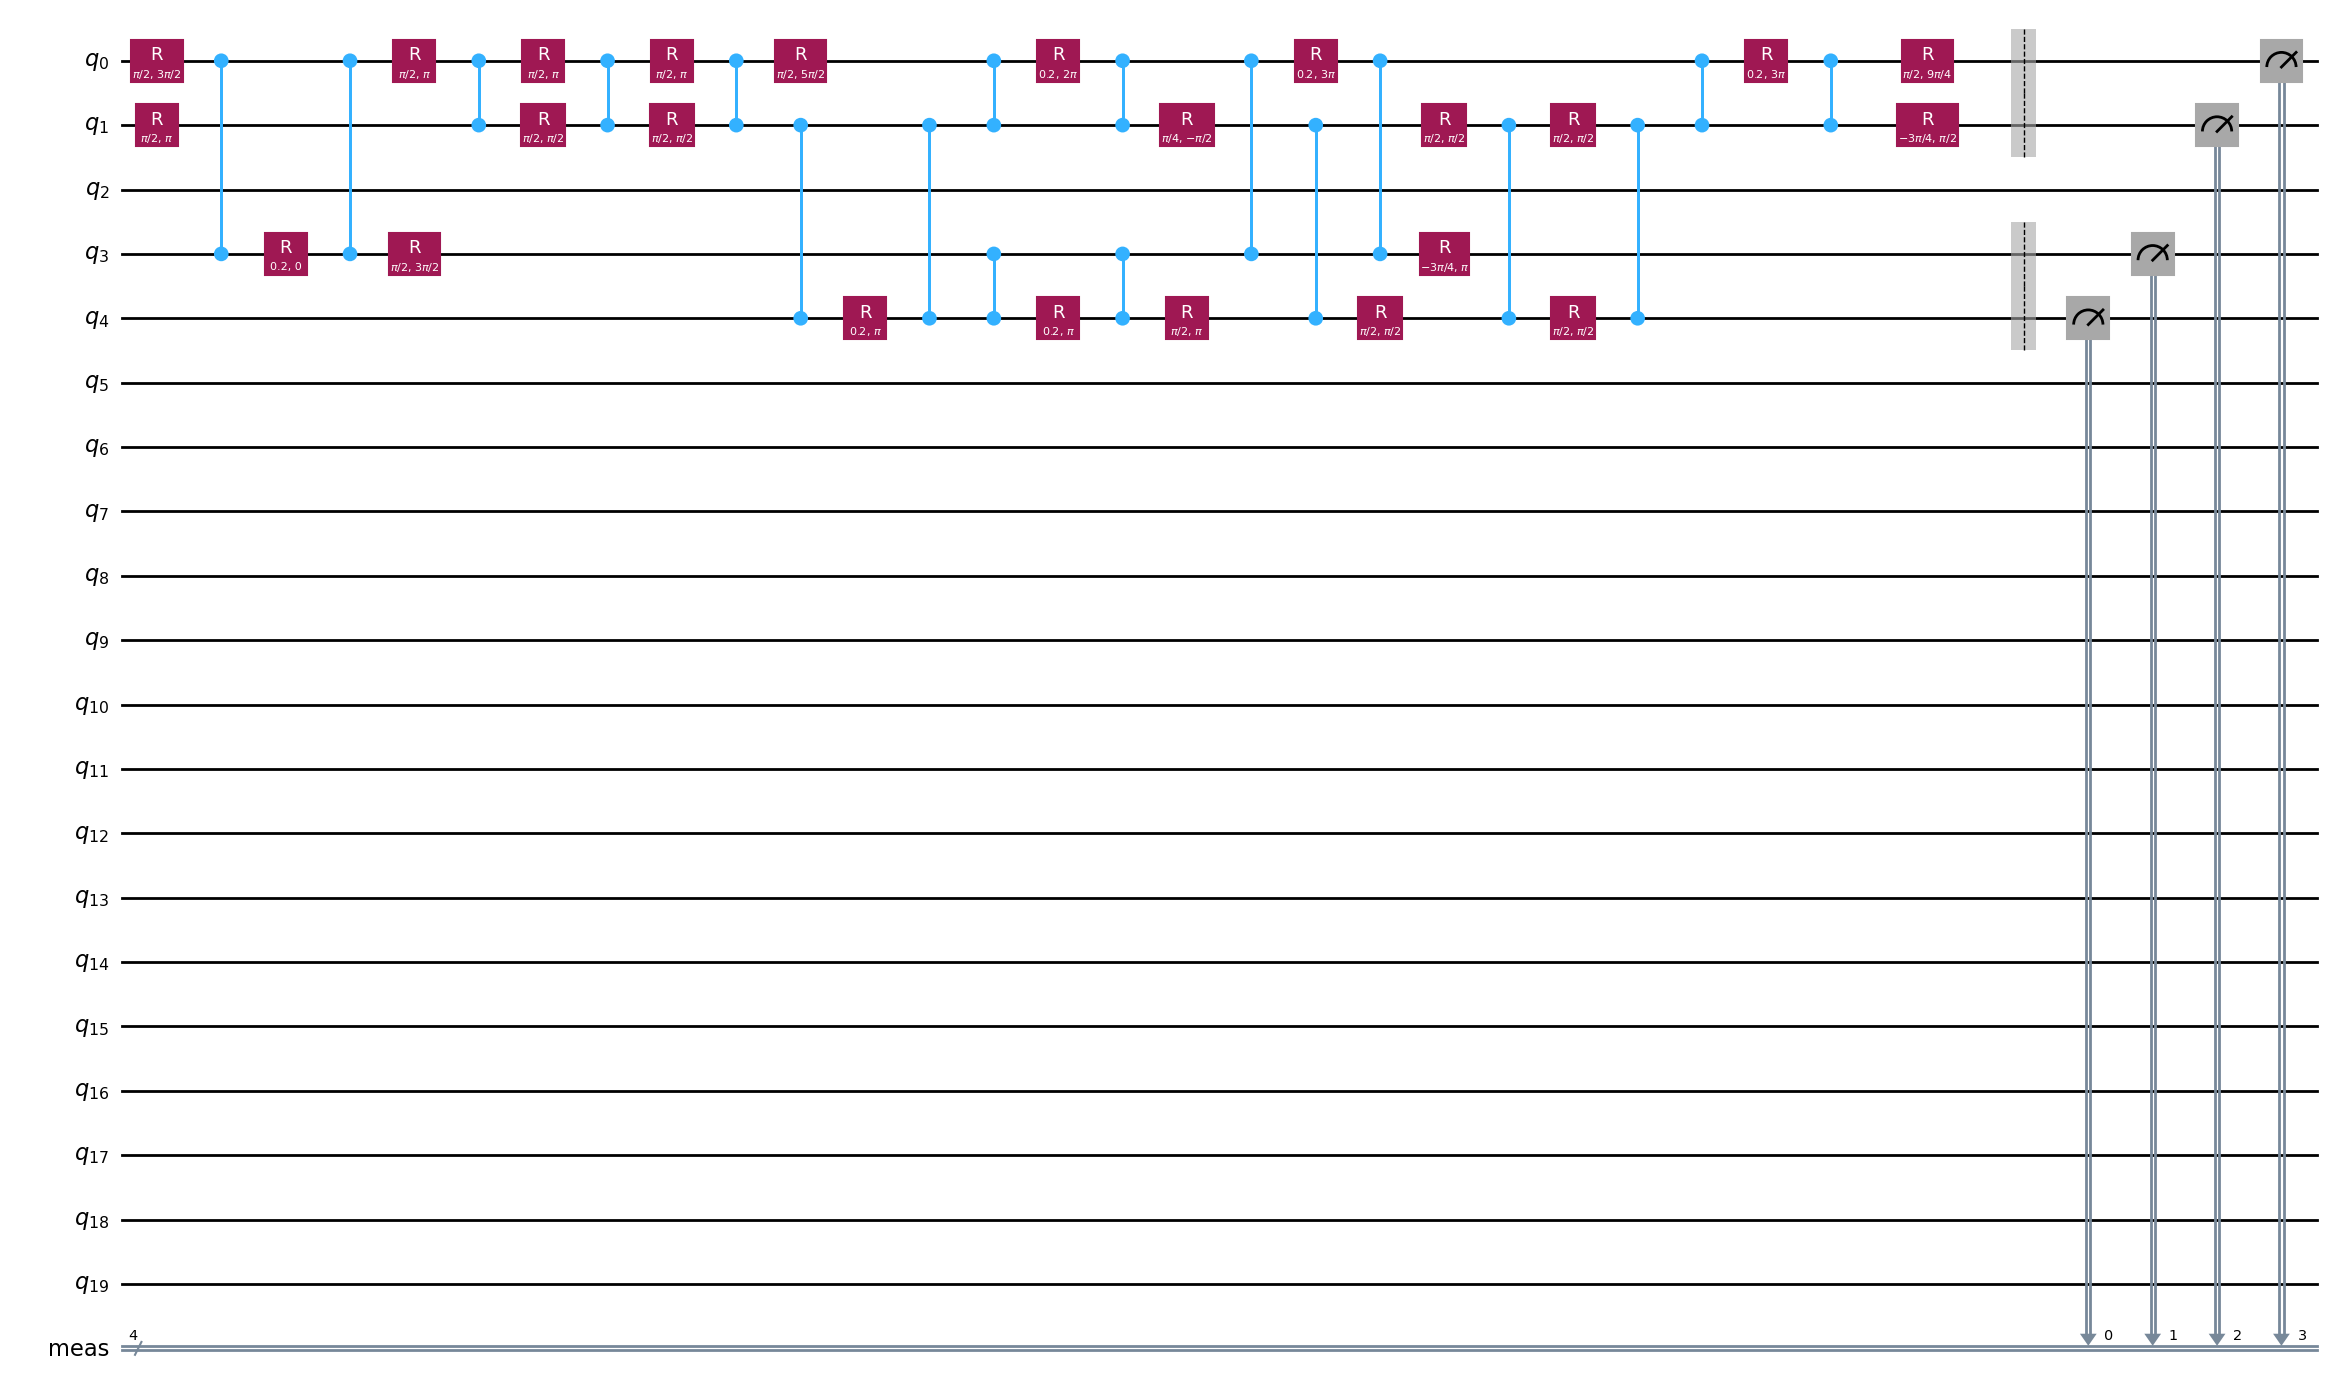

In [5]:
from scipy.optimize import minimize
from src.hw_src import get_energy_p1
from qiskit.compiler import transpile
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

best_result = None
best_theta = None
best_fun_value = float('inf')
theta_0 = [0.5, -np.pi/8]   # these are the expected angles for the SK model
bounds = [(theta_0[0]-0.6, theta_0[0]+0.6), (theta_0[1]-np.pi/4, theta_0[1]+np.pi/4)]
w = np.zeros(num_qubits)   # w is a vector corresponding to local fields in the Hamiltonian (absent here)
number_initial_angles = 20
for t0 in [theta_0] + np.random.uniform(-np.pi, np.pi, (number_initial_angles,2)).tolist():
    result = minimize(get_energy_p1, t0, args=(W, w), bounds=bounds)
    theta = result.x
    if result.fun < best_fun_value:
        best_fun_value = result.fun
        best_theta = theta
        best_result = result


theta_opt = best_theta
circ_qaoa = create_qaoa_circuit(num_qubits, theta, W)
circ_qaoa_transpiled = transpile(circ_qaoa, backend, optimization_level=3)            
circ_qaoa_1 = optimize_single_qubit_gates(circ_qaoa_transpiled)
circ_qaoa_1.draw("mpl", fold=-1)


Now let's take a look at the number of two-qubit `cz` gates and at the **depth** of the circuit.

In [6]:
print('number of two-qubit cz gates:', circ_qaoa_1.count_ops()['cz'])
print('depth of the circuit:', circ_qaoa_1.depth())

number of two-qubit cz gates: 18
depth of the circuit: 27


The circuit `circ_qaoa_1` is not optimal, as we will show in the following building an optimal circuit.

First, select a set of qubits that form a **square** on the Garnet QPU, say qubits [13, 14, 9, 8]. 

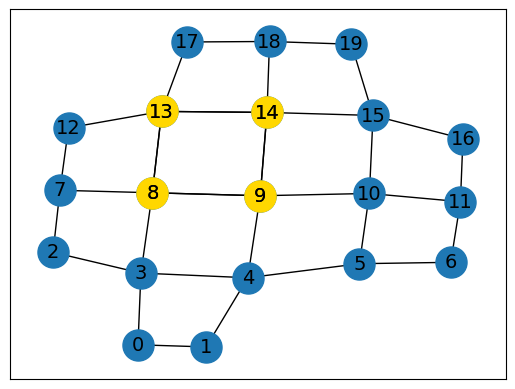

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

n4 =  [13, 14, 9, 8]  

G_rx = backend.coupling_map.graph
G_rx_nodes = list(G_rx.node_indices())
G_rx_edges = [(src, tgt) for src, tgt in G_rx.edge_list()]
G_nx = nx.Graph()
G_nx.add_nodes_from(G_rx_nodes)
G_nx.add_edges_from(G_rx_edges)

initial_layout = n4
G_cmap = nx.subgraph(G_nx, initial_layout)

plt.figure()
nx.draw_networkx(G_nx, with_labels=True, node_size=500, font_size=14, pos = nx.spring_layout(G_nx, seed=51))
nx.draw_networkx(G_cmap, with_labels=True, node_size=500, node_color='gold', font_size=14,
                 pos = nx.spring_layout(G_nx, seed=51))
plt.show()

Now we can build the circuit as follows:

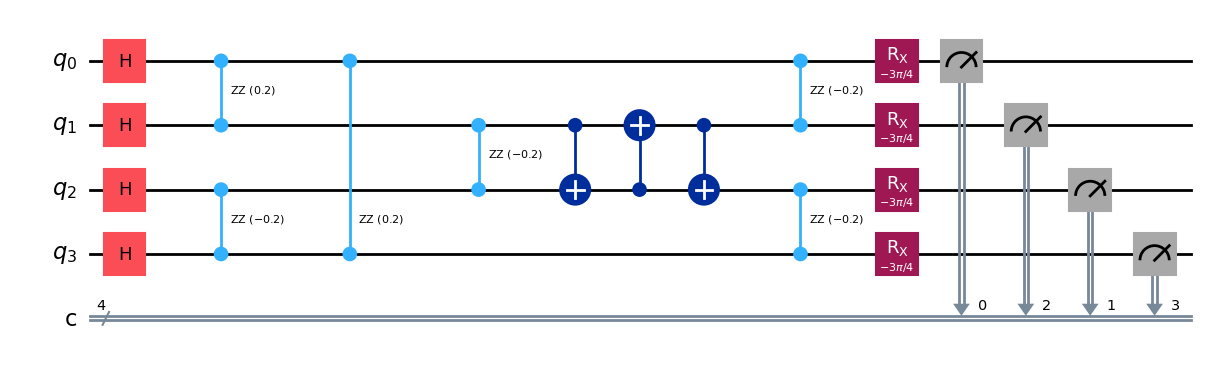

In [8]:
from src.hw_src import swap_bit_indices

qc = IQMCircuit(num_qubits, num_qubits)
cl_bits = np.arange(num_qubits).tolist()

gamma = theta[0]
beta = theta[1]

# initializing the quantum register in a uniform superposition state
for i in range(num_qubits):
    qc.h(i)

# problem circuit
qc.rzz(2 * W[cl_bits[0]][cl_bits[1]] * gamma , 0, 1)
qc.rzz(2 * W[cl_bits[2]][cl_bits[3]] * gamma , 2, 3)
qc.rzz(2 * W[cl_bits[0]][cl_bits[3]] * gamma , 0, 3)
qc.rzz(2 * W[cl_bits[1]][cl_bits[2]] * gamma , 1, 2)
qc.cx(1, 2)
qc.cx(2, 1)
qc.cx(1, 2)
cl_bits = swap_bit_indices(cl_bits, 1, 2)
qc.rzz(2 * W[cl_bits[0]][cl_bits[1]] * gamma , 0, 1)
qc.rzz(2 * W[cl_bits[2]][cl_bits[3]] * gamma , 2, 3)
        
### mixer
for i in range(num_qubits):
    qc.rx(2 * beta, i)

qc.measure(np.arange(num_qubits).tolist(), cl_bits)

display(qc.draw("mpl", fold=-1))

Note that in the circuit above (non transpiled) the used qubits are qubits [0, 1, 2, 3]. In the transpiled version below these are mapped to the qubits in the square layout that we chose before.

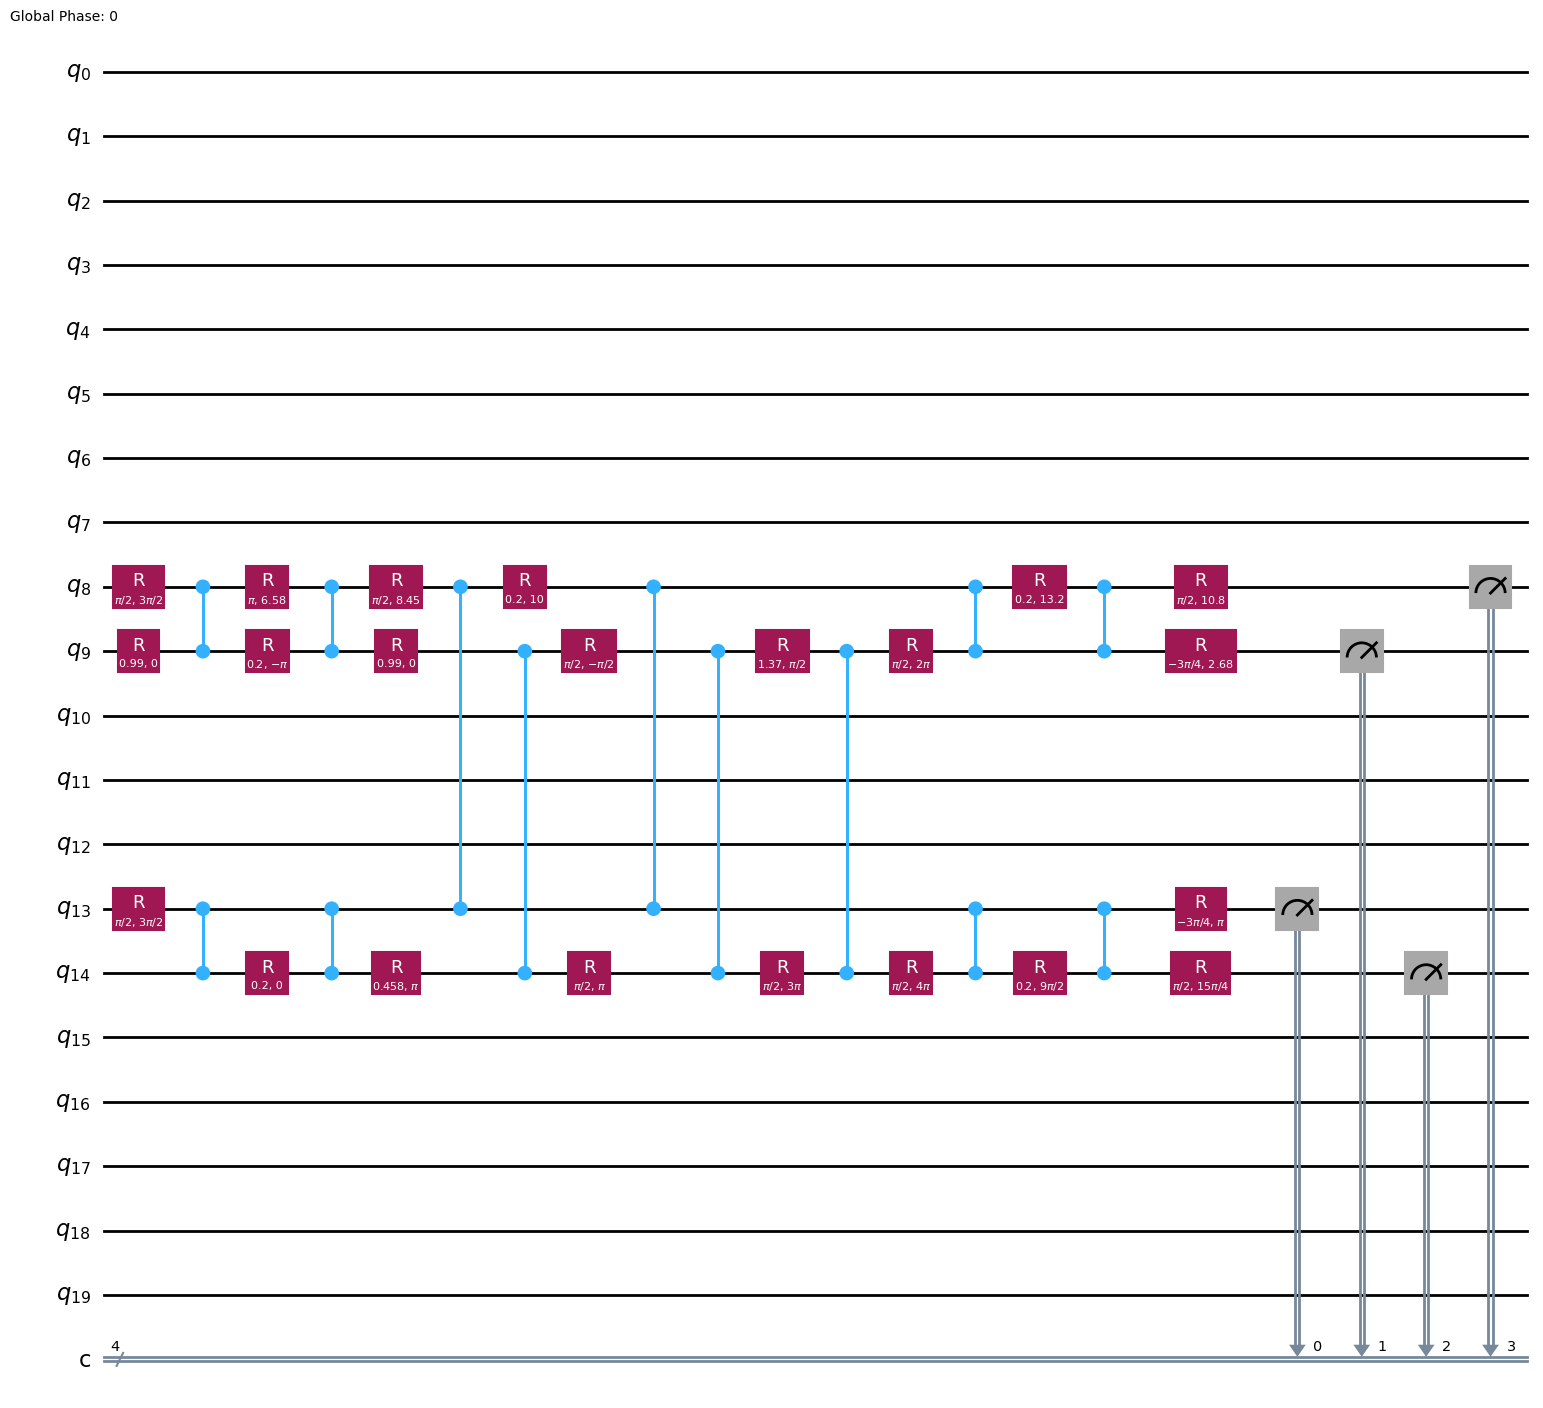

number of two-qubit cz gates: 13
depth of the circuit: 16


In [9]:
qc_transpiled = transpile(qc, backend, optimization_level=3, initial_layout=n4)            
circ_qaoa_opt = optimize_single_qubit_gates(qc_transpiled)

display(circ_qaoa_opt.draw("mpl", fold=-1))

print('number of two-qubit cz gates:', circ_qaoa_opt.count_ops()['cz'])
print('depth of the circuit:', circ_qaoa_opt.depth())

We can see that the circuit `circ_qaoa_opt` has **fewer** two-qubit gates and also is **shallower**.

In constructing the optimal circuit (hardwired circuit), we have taken advantage of the following facts:
* commutativity of interactions in QAOA (problem) Hamiltonian
* IQM Garnet square lattice topology

With these considerations, we can arrange the ZZ interactions in such a way that more gates are executable in parallel, and also place the `SWAP` gates next to the ZZ interaction to cancel out two `cz` gates.

In the following, we compare the circuits obtained based on the above approach with those transpiled by the Qiskit transpiler for `num_qubits` in the range `[4, 5, 6, 7, 8, 9, 10]`.

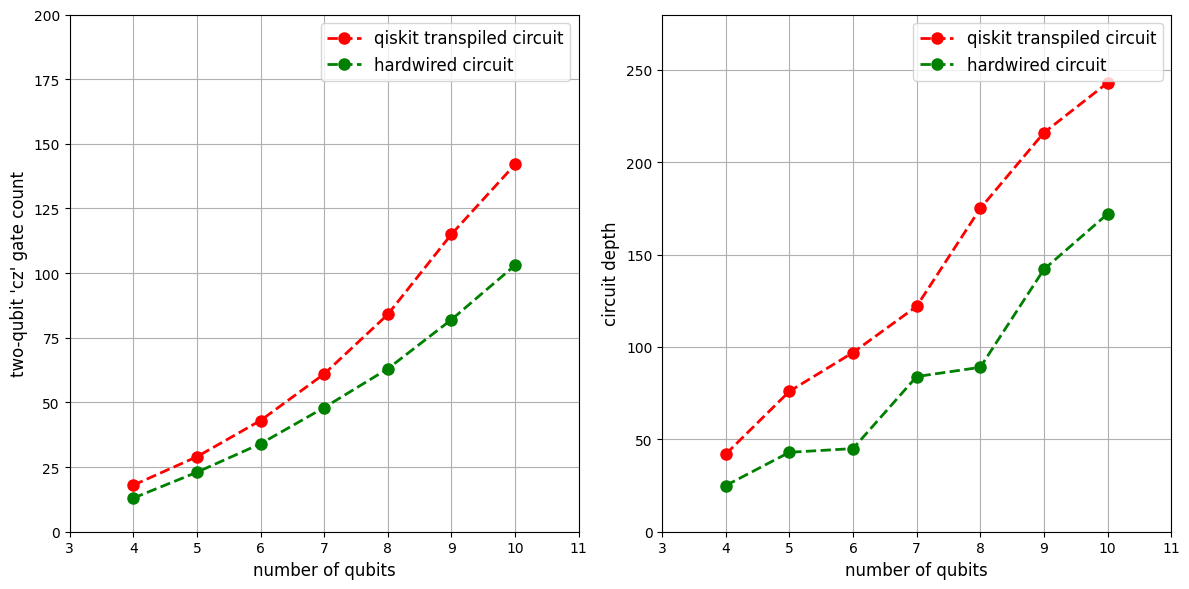

In [ ]:
from src.hw_src import hw_qaoa_transpile
from src.utils import get_calibration_data

QPU = 'Garnet'
calibration_data = get_calibration_data(QPU, token)
qubit_range = [4, 5, 6, 7, 8, 9, 10]

### building the circuits
theta = [Parameter("$\\gamma$"), Parameter("$\\beta$")]
qc_general_list = []
qc_hardwired_list = []
for num_qubits in qubit_range:

    W = np.zeros((num_qubits, num_qubits), dtype=int)
    triu_indices = np.triu_indices(num_qubits, k=1)
    np.random.seed(888)
    W[triu_indices] = np.random.choice([-1, 1], size=num_qubits*(num_qubits-1)//2)
    W = W + W.T

    w = np.zeros(num_qubits)
    
    ### building the circuit - qiskit general transpilation
    qc_naive = create_qaoa_circuit(num_qubits, theta, W)
    qc_naive_transpiled = transpile(qc_naive, backend, optimization_level=3)            
    qc_naive_1qopt = optimize_single_qubit_gates(qc_naive_transpiled)
    qc_general_list.append(qc_naive_1qopt)

    ### building the circuit - hardwired circuit
    num_layers = 1
    qc_hw = hw_qaoa_transpile(num_qubits, num_layers, theta, W, w, backend, calibration_data)
    qc_hardwired_list.append(qc_hw)


### comparing the circuits
qc_general_gate_list = []
qc_hardwired_gate_list = []
for lindex in range(len(qubit_range)):
        qc_general_gate_list.append([qc_general_list[lindex].count_ops()['cz'], qc_general_list[lindex].depth()])
        qc_hardwired_gate_list.append([qc_hardwired_list[lindex].count_ops()['cz'], qc_hardwired_list[lindex].depth()])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

axes[0].plot(qubit_range, np.array(qc_general_gate_list)[:,0], color = 'r', marker='o', markerfacecolor='r', markersize=8,
                                    linestyle='--', linewidth=2, label='qiskit transpiled circuit')
axes[0].plot(qubit_range, np.array(qc_hardwired_gate_list)[:,0], color = 'g', marker='o', markerfacecolor='g', markersize=8,
                                    linestyle='--', linewidth=2, label='hardwired circuit')

axes[1].plot(qubit_range, np.array(qc_general_gate_list)[:,1], color = 'r', marker='o', markerfacecolor='r', markersize=8,
                                    linestyle='--', linewidth=2, label='qiskit transpiled circuit')
axes[1].plot(qubit_range, np.array(qc_hardwired_gate_list)[:,1], color = 'g', marker='o', markerfacecolor='g', markersize=8,
                                    linestyle='--', linewidth=2, label='hardwired circuit')


axes[0].set_xlim([3, 11])
axes[0].set_ylim([0, 200])
axes[0].set_xlabel('number of qubits', fontsize=12)
axes[0].set_ylabel("two-qubit 'cz' gate count", fontsize=12)
axes[0].grid(True)
axes[0].legend(fontsize=12)

axes[1].set_xlim([3, 11])
axes[1].set_ylim([0, 280])
axes[1].set_xlabel('number of qubits', fontsize=12)
axes[1].set_ylabel('circuit depth', fontsize=12)
axes[1].grid(True)
axes[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


## Running QAOA on IQM Garnet



For large systems, the average energy density over many realizations of the couplings $J_{ij}$ is known to be around -0.3 for single-layer QAOA. This is calculated by measuring the expected energy from a single-layer QAOA circuit and dividing it by $n^{1.5}$, where $n$ is the number of qubits.

Let's check this first on a **noiseless simulator**, for the number of qubits in the range `[4, 5, 6, 7, 8]` and 20 instances for each system size.
 
**Warning**: This could take few minutes to run.


In [11]:
from src.hw_src import obj_fun_expectation

### generating W's and w's and optimizing QAOA p=1 angles
theta_0 = [1/2, -np.pi/8]
bounds = [(-np.pi, np.pi), (-np.pi, np.pi)]
qubit_range = [4, 5, 6, 7, 8]
num_instance = 20

### building the circuits
W_list = []
w_list = []
theta_list = []
for num_qubits in qubit_range:

    W_ins = []
    w_ins = []
    theta_ins = []
    for ni in range(num_instance):

        ### W (couplings = adjacency matrix) and w (weights)
        W = np.zeros((num_qubits, num_qubits), dtype=int)
        triu_indices = np.triu_indices(num_qubits, k=1)
        W[triu_indices] = np.random.choice([-1, 1], size=num_qubits*(num_qubits-1)//2)
        W = W + W.T
        W_ins.append(W)

        w = np.zeros(num_qubits)
        w_ins.append(w)
       

        ### optimizing the angles
        best_result = None
        best_theta = None
        best_fun_value = float('inf')
        for t0 in [theta_0] + np.random.uniform(-np.pi, np.pi, (20,2)).tolist():
            result = minimize(get_energy_p1, t0, args=(W, w), bounds=bounds)
            theta = result.x

            if result.fun < best_fun_value:
                best_fun_value = result.fun
                best_theta = theta
                best_result = result

        theta_ins.append(best_theta)

    W_list.append(W_ins)
    w_list.append(w_ins)
    theta_list.append(theta_ins)



### building the circuits
opt_level = 3
qc_general_list = []
qc_hardwired_list = []
for lindex in range(len(qubit_range)):
    
    num_qubits = qubit_range[lindex]
    qc_general_ins = []
    qc_hardwired_ins = []
    for ni in range(num_instance):

        ### building the circuit - qiskit general transpilation
        qc_naive = create_qaoa_circuit(num_qubits, theta_list[lindex][ni], W_list[lindex][ni])
        qc_naive_transpiled = transpile(qc_naive, backend, optimization_level=opt_level)            
        qc_naive_1qopt = optimize_single_qubit_gates(qc_naive_transpiled)
        qc_general_ins.append(qc_naive_1qopt)

        ### building the circuit - hardwired circuit
        qc_hw = hw_qaoa_transpile(num_qubits, num_layers, theta_list[lindex][ni],
                                  W_list[lindex][ni], w_list[lindex][ni], backend, calibration_data)
        qc_hardwired_ins.append(qc_hw)

    qc_general_list.append(qc_general_ins)
    qc_hardwired_list.append(qc_hardwired_ins)


Now we can execute all the circuits constructed above:

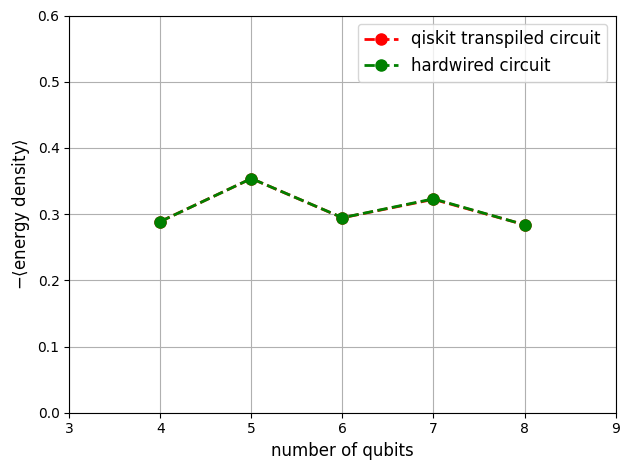

In [12]:
### Execution - all instances on the simulator
from qiskit_aer import Aer

sim_backend = Aer.get_backend('aer_simulator_statevector')
num_shots = 20000

qc_general_counts_list = []
qc_hardwired_counts_list = []
qc_general_mean_energy_list = []
qc_hardwired_mean_energy_list = []
for lindex in range(len(qubit_range)):
    
    num_qubits = qubit_range[lindex]
    counts_gen_ins = []
    counts_hw_ins = []
    energy_gen_ins = np.zeros((num_instance))
    energy_hw_ins = np.zeros((num_instance))
    for ni in range(num_instance):

        counts_gen = sim_backend.run(qc_general_list[lindex][ni], shots=num_shots).result().get_counts()
        counts_hw = sim_backend.run(qc_hardwired_list[lindex][ni], shots=num_shots).result().get_counts()

        counts_gen_ins.append(counts_gen)
        counts_hw_ins.append(counts_hw)

        energy_gen_ins[ni] = obj_fun_expectation(counts_gen, W_list[lindex][ni], w_list[lindex][0])/(-num_qubits**1.5)
        energy_hw_ins[ni] = obj_fun_expectation(counts_hw, W_list[lindex][ni], w_list[lindex][0])/(-num_qubits**1.5)

    qc_general_counts_list.append(counts_gen_ins)
    qc_hardwired_counts_list.append(counts_hw_ins)

    qc_general_mean_energy_list.append(np.mean(energy_gen_ins))
    qc_hardwired_mean_energy_list.append(np.mean(energy_hw_ins))


qc_general_mean_energy_list_sim = qc_general_mean_energy_list
qc_hardwired_mean_energy_list_sim = qc_hardwired_mean_energy_list
### energies
plt.plot(qubit_range, qc_general_mean_energy_list_sim, color = 'r', marker='o', markerfacecolor='r', markersize=8,
                                    linestyle='--', linewidth=2, label='qiskit transpiled circuit')
plt.plot(qubit_range, qc_hardwired_mean_energy_list_sim, color = 'g', marker='o', markerfacecolor='g', markersize=8,
                                    linestyle='--', linewidth=2, label='hardwired circuit')

plt.xlim([3, 9])
plt.ylim([0, 0.6])
plt.xlabel('number of qubits', fontsize=12)
plt.ylabel(r"$-\langle \text{energy density} \rangle$", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


We can see how the noiseless results for the circuits transpiled with the two different methods **coincide**.

Now we execute the circuits on IQM Garnet. The submission of the jobs and retrieval of the results can take several minutes to run. 

We start with the optimized circuits:

In [20]:
### qc_hardwired_list
from src.executor import Resonance_batched_executor

quantum_circuits_hw = []
for lindex in range(len(qubit_range)):
    for ni in range(num_instance):
        quantum_circuits_hw.append(qc_hardwired_list[lindex][ni])


num_shots = 20000
executor = Resonance_batched_executor(backend, max_circuit=1)
executor.run('results/result_hw', quantum_circuits_hw, num_shots)

Dealing with 100 circuits, 9.819e+03 instructions, and 2.000e+06 total shots.
Created 100 batches!
Optimistic and approximate runtime: 2900.0 seconds
beginning first submission!


After all the submitted jobs were executed, we need to retrieve the results from the Garnet (This can take few minutes. After the first retrieval, you can change `update` to `False`).

In [25]:
complete_counts = executor.return_results('results/result_hw', update=True)

All batches finished; presenting final results in original list form


We do the same for the non-optimized ones:

In [24]:
### qc_general_list
quantum_circuits_gen = []
for lindex in range(len(qubit_range)):
    for ni in range(num_instance):
        quantum_circuits_gen.append(qc_general_list[lindex][ni])


executor = Resonance_batched_executor(backend, max_circuit=1)
executor.run('results/result_gen', quantum_circuits_gen, num_shots)

Dealing with 100 circuits, 1.109e+04 instructions, and 2.000e+06 total shots.
Created 100 batches!
Optimistic and approximate runtime: 2900.0 seconds
resuming on: [('CANCELLED', 0), ('DONE', 18), ('ERROR', 0), ('INITIALIZING', 0), ('QUEUED', 64), ('RUNNING', 0), ('VALIDATING', 0)]


In [26]:
complete_counts_gen = executor.return_results('results/result_gen', update=True)

All batches finished; presenting final results in original list form


Let's compare all the results!

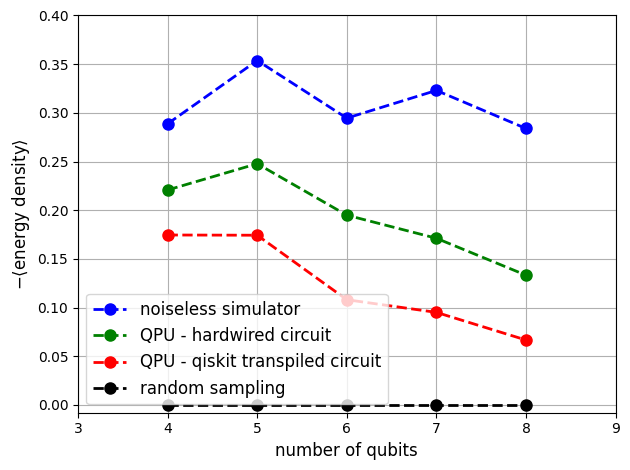

In [27]:
qc_general_counts_list = []
qc_hardwired_counts_list = []
qc_general_mean_energy_list = []
qc_hardwired_mean_energy_list = []
for lindex in range(len(qubit_range)):
    
    num_qubits = qubit_range[lindex]
    counts_gen_ins = []
    counts_hw_ins = []
    energy_gen_ins = np.zeros((num_instance))
    energy_hw_ins = np.zeros((num_instance))
    for ni in range(num_instance):
        ll = lindex*num_instance + ni

        counts_gen = complete_counts_gen[ll] 
        counts_hw = complete_counts[ll] 

        counts_gen_ins.append(counts_gen)
        counts_hw_ins.append(counts_hw)

        energy_gen_ins[ni] = obj_fun_expectation(counts_gen, W_list[lindex][ni], w_list[lindex][ni])/(-num_qubits**1.5)
        energy_hw_ins[ni] = obj_fun_expectation(counts_hw, W_list[lindex][ni], w_list[lindex][ni])/(-num_qubits**1.5)

    qc_general_counts_list.append(counts_gen_ins)
    qc_hardwired_counts_list.append(counts_hw_ins)

    qc_general_mean_energy_list.append(np.mean(energy_gen_ins))
    qc_hardwired_mean_energy_list.append(np.mean(energy_hw_ins))

qc_general_mean_energy_list_QPU = qc_general_mean_energy_list
qc_hardwired_mean_energy_list_QPU = qc_hardwired_mean_energy_list


plt.plot(qubit_range, qc_hardwired_mean_energy_list_sim, color = 'b', marker='o', markerfacecolor='b', markersize=8,
                                    linestyle='--', linewidth=2, label='noiseless simulator')

plt.plot(qubit_range, qc_hardwired_mean_energy_list_QPU, color = 'g', marker='o', markerfacecolor='g', markersize=8,
                                    linestyle='--', linewidth=2, label='QPU - hardwired circuit')
plt.plot(qubit_range, qc_general_mean_energy_list_QPU, color = 'r', marker='o', markerfacecolor='r', markersize=8,
                                    linestyle='--', linewidth=2, label='QPU - qiskit transpiled circuit')


plt.plot(qubit_range, np.zeros(len(qubit_range)), color = 'k', marker='o', markerfacecolor='k', markersize=8,
                                    linestyle='--', linewidth=2, label='random sampling')
plt.xlim([3, 9])
plt.ylim([-0.008, 0.4])
plt.xlabel('number of qubits', fontsize=12)
plt.ylabel(r"$-\langle \text{energy density} \rangle$", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


We were able to run a QAOA circuit on IQM Garnet for the SK model! We can see that the results from the quantum hardware are closer to the noiseless ones in the case of the hardwired circuits: Thanks to the optimized transpilation, we were able to reach better performance for all sizes of the problem 🎉


## Take it further

Now it's your turn. Start from the code above. Experiment with other graphs or check out IQM Garnet with other problems.

In [ ]:

# Copyright 2024 IQM Quantum Computers (Jalil Khatibi Moqadam, Elisabeth Wybo, Nadia Milazzo, Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.